Understand and measure the impact of the campaign they ran. 

In [1]:
from causalimpact import CausalImpact
import pandas as pd

C:\Users\Ibiene\AppData\Roaming\Python\Python39\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [3]:
transactions = pd.read_excel("data/grocery_database.xlsx", sheet_name = "transactions")
campaign_data = pd.read_excel("data/grocery_database.xlsx", sheet_name = "campaign_data")

In [14]:
transactions.head(6)

,customer_id,transaction_date,transaction_id,product_area_id,num_items,sales_cost
0,1,2020-04-10,435657533999,3,7,19.16
1,1,2020-04-10,435657533999,2,5,7.71
2,1,2020-06-02,436189770685,4,4,26.97
3,1,2020-06-02,436189770685,1,2,38.52
4,1,2020-06-10,436265380298,4,4,22.13
5,1,2020-06-10,436265380298,1,2,34.23


need to aggregate up to customer data level

In [15]:
campaign_data.head()

,customer_id,campaign_name,campaign_date,mailer_type,signup_flag
0,74,delivery_club,2020-07-01,Mailer1,1
1,524,delivery_club,2020-07-01,Mailer1,1
2,607,delivery_club,2020-07-01,Mailer2,1
3,343,delivery_club,2020-07-01,Mailer1,0
4,322,delivery_club,2020-07-01,Mailer2,1


In [16]:
customer_daily_sales = transactions.groupby(["customer_id", "transaction_date"])["sales_cost"].sum().reset_index()


In [17]:
customer_daily_sales = pd.merge(customer_daily_sales, campaign_data, how="inner", on = "customer_id")
customer_daily_sales

,customer_id,transaction_date,sales_cost,campaign_name,campaign_date,mailer_type,signup_flag
0,1,2020-04-10,26.87,delivery_club,2020-07-01,Mailer2,1
1,1,2020-06-02,65.49,delivery_club,2020-07-01,Mailer2,1
2,1,2020-06-10,71.71,delivery_club,2020-07-01,Mailer2,1
3,1,2020-06-19,61.91,delivery_club,2020-07-01,Mailer2,1
4,1,2020-07-02,471.71,delivery_club,2020-07-01,Mailer2,1
...,...,...,...,...,...,...,...
16974,870,2020-08-23,24.10,delivery_club,2020-07-01,Mailer1,0
16975,870,2020-08-28,84.56,delivery_club,2020-07-01,Mailer1,0
16976,870,2020-09-21,186.87,delivery_club,2020-07-01,Mailer1,0
16977,870,2020-09-23,145.49,delivery_club,2020-07-01,Mailer1,0


In [18]:
#picot the data to aggreagte daily sales by signup group

causal_impact_df = customer_daily_sales.pivot_table(index = "transaction_date", 
                                                    columns = "signup_flag", 
                                                    values = "sales_cost",
                                                   aggfunc = "mean")

In [19]:
causal_impact_df

signup_flag,0,1
transaction_date,,
2020-04-01,74.463333,194.488065
2020-04-02,75.558254,185.161667
2020-04-03,74.387353,118.121333
2020-04-04,63.003797,198.525357
2020-04-05,72.440441,145.456000
...,...,...
2020-09-26,67.471786,189.737419
2020-09-27,91.421525,237.735357
2020-09-28,65.681692,157.158750


In [20]:
causal_impact_df.index

DatetimeIndex(['2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04',
               '2020-04-05', '2020-04-06', '2020-04-07', '2020-04-08',
               '2020-04-09', '2020-04-10',
               ...
               '2020-09-21', '2020-09-22', '2020-09-23', '2020-09-24',
               '2020-09-25', '2020-09-26', '2020-09-27', '2020-09-28',
               '2020-09-29', '2020-09-30'],
              dtype='datetime64[ns]', name='transaction_date', length=183, freq=None)

In [21]:
causal_impact_df.index.freq= "D" 

In [22]:
causal_impact_df.index

DatetimeIndex(['2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04',
               '2020-04-05', '2020-04-06', '2020-04-07', '2020-04-08',
               '2020-04-09', '2020-04-10',
               ...
               '2020-09-21', '2020-09-22', '2020-09-23', '2020-09-24',
               '2020-09-25', '2020-09-26', '2020-09-27', '2020-09-28',
               '2020-09-29', '2020-09-30'],
              dtype='datetime64[ns]', name='transaction_date', length=183, freq='D')

In [23]:
# for causal impac, we need the impacted group in the first column 
causal_impact_df = causal_impact_df[[1, 0]]


In [24]:
#change col names
causal_impact_df.columns = ["member", "non_member"]

In [26]:
pre_period = ["2020-04-02", "2020-06-30"]
post_period = ["2020-07-01", "2020-09-30"]

In [28]:
ci = CausalImpact(causal_impact_df, pre_period, post_period)

C:\Users\Ibiene\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: nseasons, standardize. After release 0.14, this will raise.
  warnings.warn(


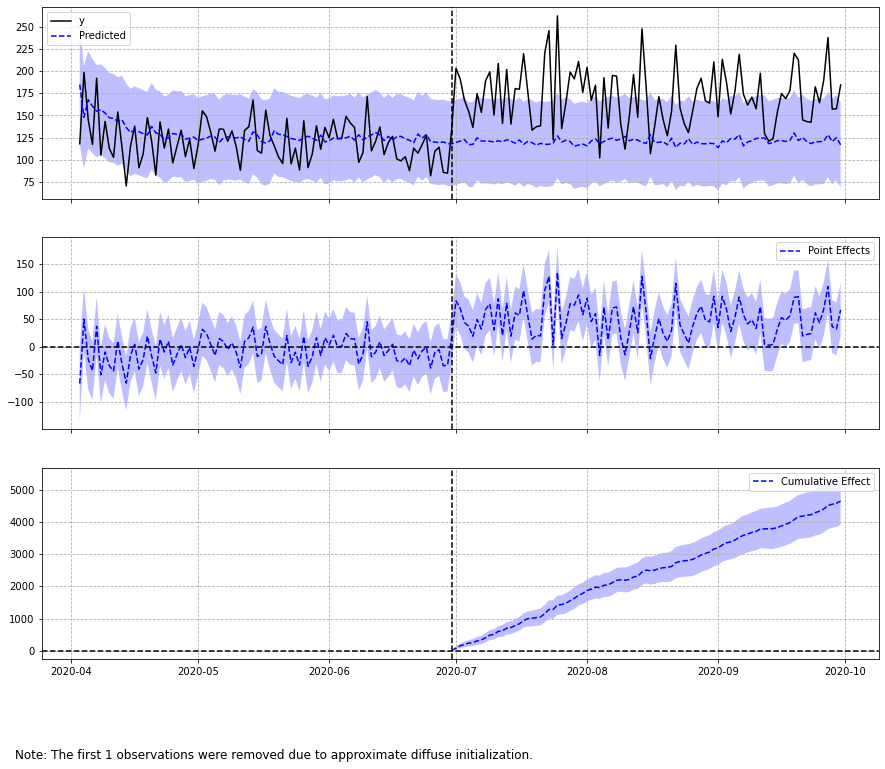

In [29]:
ci.plot()

In [30]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    171.33             15762.67
Prediction (s.d.)         120.77 (4.21)      11110.93 (387.02)
95% CI                    [112.39, 128.88]   [10339.94, 11857.04]

Absolute effect (s.d.)    50.56 (4.21)       4651.75 (387.02)
95% CI                    [42.45, 58.94]     [3905.63, 5422.73]

Relative effect (s.d.)    41.87% (3.48%)     41.87% (3.48%)
95% CI                    [35.15%, 48.81%]   [35.15%, 48.81%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [31]:
print(ci.summary(output = "report"))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 171.33. By contrast, in the absence of an
intervention, we would have expected an average response of 120.77.
The 95% interval of this counterfactual prediction is [112.39, 128.88].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 50.56 with a 95% interval of
[42.45, 58.94]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 15762.67.
By contrast, had the intervention not taken place, we would have expected
a sum of 11110.93. The 95% interval of this prediction is [10339.94, 11857.04].


The above results are given in terms of absolute numbers. In relative
terms, the res